In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import logomaker
from tqdm.notebook import tqdm

from netam.sequences import translate_sequence
from netam.framework import load_crepe
from netam.common import heavy_chain_shim

from dnsmex.dxsm_data import dataset_dict
from dnsmex.local import localify
from dnsmex.dxsm_zoo import dxsm_pick_device

figures_dir = localify("FIGURES_DIR")

We'd like to investigate how natural selection looks on a dataset that wasn't used to train the model. So let's choose a model trained on the Tang data.

In [2]:
crepe_path = "../../dnsm-train/trained_models/dnsm_1m-v1tang-joint"
crepe = load_crepe(crepe_path)

device = dxsm_pick_device()
crepe.to(device)
crepe = heavy_chain_shim(crepe)

GPU chosen via memory
Using CUDA GPU 0


We will investigate it on the 10X data.

In [4]:
min_family_size = 10
full_pcp_df = pd.read_csv(dataset_dict["v1jaffe"], index_col=0)
full_pcp_df["v_family_heavy"] = full_pcp_df["v_gene_heavy"].str.split("-").str[0]
#pcp_df = full_pcp_df[full_pcp_df["v_family"].isin(["IGHV3", "IGHV4"])].reset_index(drop=True)
pcp_df = full_pcp_df.copy()
# true clonal family identifier is sample_id + family
pcp_df["clonal_family"] = pcp_df["sample_id"] + "_" + pcp_df["family"].astype(str)
top_families = pcp_df["clonal_family"].value_counts()
top_families = set(top_families[top_families >= min_family_size].index)
pcp_df = pcp_df[pcp_df["clonal_family"].isin(top_families)].reset_index(drop=True)
len(pcp_df)

74824

Text(0.5, 0, 'Clonal family size')

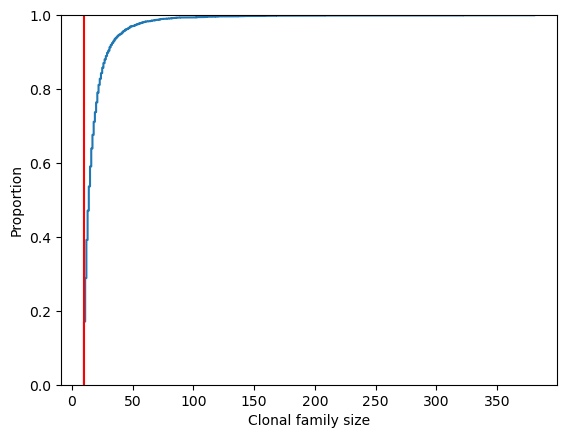

In [5]:
sns.ecdfplot(pcp_df.groupby(["family", "sample_id"]).size())
plt.axvline(min_family_size, color="red")
plt.xlabel("Clonal family size")

In [7]:
def seq_df_of_pcp_df(pcp_df):
    columns = [
        'sample_id', 'clonal_family', 'name', 'seq', 'depth', 'distance', 'v_gene', 
        'cdr1_codon_start', 'cdr1_codon_end', 
        'cdr2_codon_start', 'cdr2_codon_end', 
        'cdr3_codon_start', 'cdr3_codon_end', 
        'is_naive', 'is_leaf', 'v_family'
    ]
    seq_df = pd.DataFrame(columns=columns)

    added_sequences = {}

    def add_sequence(row, name_type, seq_type, is_parent):
        key = (row['sample_id'], row['family'], row[name_type])
        if key not in added_sequences:
            new_row = {
                'sample_id': row['sample_id'],
                'clonal_family': row['clonal_family'],
                'name': row[name_type],
                'seq': row[seq_type],
                'depth': row['depth'],
                'distance': row['distance'],
                'v_gene': row['v_gene_heavy'],
                'cdr1_codon_start': row['cdr1_codon_start_heavy'],
                'cdr1_codon_end': row['cdr1_codon_end_heavy'],
                'cdr2_codon_start': row['cdr2_codon_start_heavy'],
                'cdr2_codon_end': row['cdr2_codon_end_heavy'],
                'cdr3_codon_start': row['cdr3_codon_start_heavy'],
                'cdr3_codon_end': row['cdr3_codon_end_heavy'],
                'is_naive': True if is_parent and row['parent_is_naive'] else False,
                'is_leaf': False if is_parent else row['child_is_leaf'],
                'v_family': row['v_family_heavy']
            }
            seq_df.loc[len(seq_df)] = new_row
            added_sequences[key] = True

    for index, row in tqdm(pcp_df.iterrows(), total=len(pcp_df), desc="Adding sequences"):
        add_sequence(row, 'parent_name', 'parent_heavy', True)  # Parent sequences, check parent_is_naive
        add_sequence(row, 'child_name', 'child_heavy', False)   # Child sequences, child_is_leaf only

    seq_df.set_index(['sample_id', 'clonal_family', 'name'], inplace=True)

    return seq_df

seq_df = seq_df_of_pcp_df(pcp_df)
print("translating sequences")
seq_df["seq_aa"] = seq_df["seq"].apply(translate_sequence)

dnsm_outputs = []
for seq in tqdm(seq_df["seq_aa"], desc="Computing dnsm outputs"):
    dnsm_outputs.append(crepe([seq])[0].cpu().numpy())

seq_df["dnsm"] = dnsm_outputs


Adding sequences:   0%|          | 0/74824 [00:00<?, ?it/s]

translating sequences


Computing dnsm outputs:   0%|          | 0/87443 [00:00<?, ?it/s]

4       1
5      25
6      56
7      45
8      89
9     162
10    209
11    323
12    361
13    392
Name: count, dtype: int64

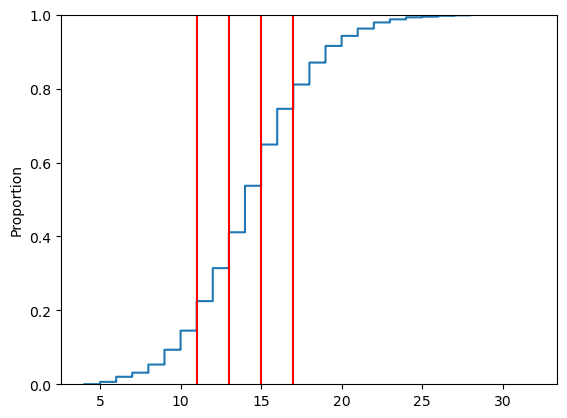

In [8]:
# Let's figure out the distribution of cdr3 lengths
# First we take one row per sample_id and family
one_row_per_sample_family = seq_df.groupby(["clonal_family"]).first()
cdr3_lengths = (one_row_per_sample_family["cdr3_codon_end"] - one_row_per_sample_family["cdr3_codon_start"])//3 + 1

quantile_count = 5
cdr3_length_quantiles = cdr3_lengths.quantile([(1/quantile_count) * i for i in range(1, quantile_count)])
# make an empirical CDF of one_row_per_sample_family["cdr3_length"]
sns.ecdfplot(data=cdr3_lengths)
# add vertical lines for the quartiles
for q in cdr3_length_quantiles:
    plt.axvline(q, color='r')

cdr3_lengths.value_counts().sort_index().head(10)

In [9]:
def aa_regions_of_row(row):
    """
    Calculate Python-style amino acid start and end positions for CDR and FWR regions from a single DataFrame row.
    
    By Python-style, we mean that the start position is inclusive and the end position is exclusive. 
    """
    # From Kevin: X_codon_end - position of the first nucleotide of the last codon in the X
    regions = {
        'CDR1': (row['cdr1_codon_start'] // 3, (row['cdr1_codon_end'] // 3) + 1),
        'CDR2': (row['cdr2_codon_start'] // 3, (row['cdr2_codon_end'] // 3) + 1),
        'CDR3': (row['cdr3_codon_start'] // 3, (row['cdr3_codon_end'] // 3) + 1)
    }
    if "dnsm" in row:
        length = len(row["dnsm"])
    elif "parent_aa" in row:
        length = len(row["parent_aa"])
    else:
        raise ValueError("Row must have either 'dnsm' or 'parent_aa' column")
    regions.update({
        'FWR1': (0, regions['CDR1'][0]),
        'FWR2': (regions['CDR1'][1], regions['CDR2'][0]),
        'FWR3': (regions['CDR2'][1], regions['CDR3'][0]),
        'FWR4': (regions['CDR3'][1], length) 
    })
    regions = {k: regions[k] for k in ['FWR1', 'CDR1', 'FWR2', 'CDR2', 'FWR3', 'CDR3', 'FWR4']}
    return regions


def compute_region_stats(seq_df):
    stats_functions = {
        'min': np.min,
        'median': np.median,
        'max': np.max,
        'q90': lambda x: np.percentile(x, 90)
    }

    # Initialize lists to hold the expanded index components and values
    index_list = []
    values = []
    distances = []

    # Iterate over each row, preserving the original MultiIndex
    for idx, row in seq_df.iterrows():
        regions = aa_regions_of_row(row)
        cdr3_length = regions['CDR3'][1] - regions['CDR3'][0]
        cdr3_length_quantile = np.digitize(cdr3_length, cdr3_length_quantiles)

        for region, (start, end) in regions.items():
            region_dnsm = row['dnsm'][start:end]
            for stat_name, func in stats_functions.items():
                if len(region_dnsm) > 0:
                    stat_value = func(region_dnsm)
                else:
                    stat_value = np.nan  # Handle empty slices

                # Extend the current index with region and statistic
                new_index = idx + (cdr3_length, cdr3_length_quantile, region, stat_name)
                index_list.append(new_index)
                values.append(stat_value)
                distances.append(row["distance"])

    # Create a MultiIndex from the list of indices
    multi_index = pd.MultiIndex.from_tuples(
        index_list, 
        names=list(seq_df.index.names) + ['cdr3_length', 'cdr3_length_quantile', 'region', 'statistic'])

    # Create the result DataFrame
    result_df = pd.DataFrame({'dnsm': values, 'distance': distances}, index=multi_index)

    # Yes, we are getting rid of the MultiIndex here, so in the end we're just using the MuliIndex to sort the columns.
    return result_df.reset_index()

region_stats_df = compute_region_stats(seq_df)
sorted_region_stats_df = region_stats_df.sort_index()

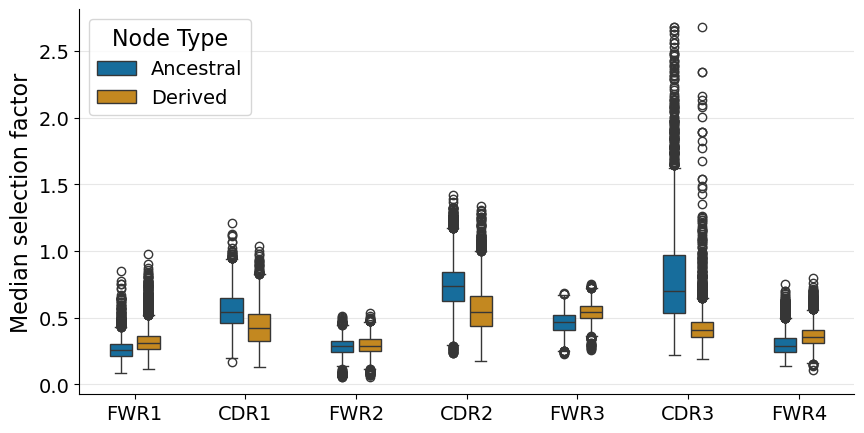

In [10]:
def ancestral_derived(region_stats_df, ax, statistic='median'):
    """
    Plot the median of the selection factors across regions for two sequences per clonal family: 
    the most ancestral (closest to the root) and the most derived (the farthest from the root in terms of branch length).
    
    Parameters:
    - region_stats_df: DataFrame containing region statistics.
    - ax: Matplotlib axis object where the plot will be drawn.
    """
    df = region_stats_df.copy()
    summary_df = df[df['statistic'] == statistic]

    # Group by sample_id and family, then find the indices of the min and max distances
    ancestral_idx = summary_df.groupby(['clonal_family', 'region'])['distance'].idxmin()
    derived_idx = summary_df.groupby(['clonal_family', 'region'])['distance'].idxmax()

    # Extract rows corresponding to ancestral and derived nodes
    ancestral_df = summary_df.loc[ancestral_idx]
    derived_df = summary_df.loc[derived_idx]

    # Mark these rows accordingly
    ancestral_df['Type'] = 'Ancestral'
    derived_df['Type'] = 'Derived'

    # Concatenate the ancestral and derived dataframes
    combined_df = pd.concat([ancestral_df, derived_df])

    sns.boxplot(
        data=combined_df,
        x='region',
        y='dnsm',
        hue='Type',
        order=['FWR1', 'CDR1', 'FWR2', 'CDR2', 'FWR3', 'CDR3', 'FWR4'],
        width=0.5,
        gap=0.2,
        palette='colorblind',
        ax=ax
    )

    sns.despine()

    # Add horizontal gridlines
    ax.grid(axis='y', linestyle='-', alpha=0.3)

    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('')
    statistic_name = statistic.capitalize()
    if statistic == 'q90':
        statistic_name = '90th quantile'
    ax.set_ylabel(f'{statistic_name} selection factor', fontsize=16)
    ax.legend(title='Node Type', loc='upper left', fontsize=14, title_fontsize=16)

fig, ax = plt.subplots(figsize=(10, 5))
ancestral_derived(region_stats_df, ax)
fig.savefig(os.path.join(figures_dir, "median_dnsm_by_region_ancestral_vs_derived.svg"))

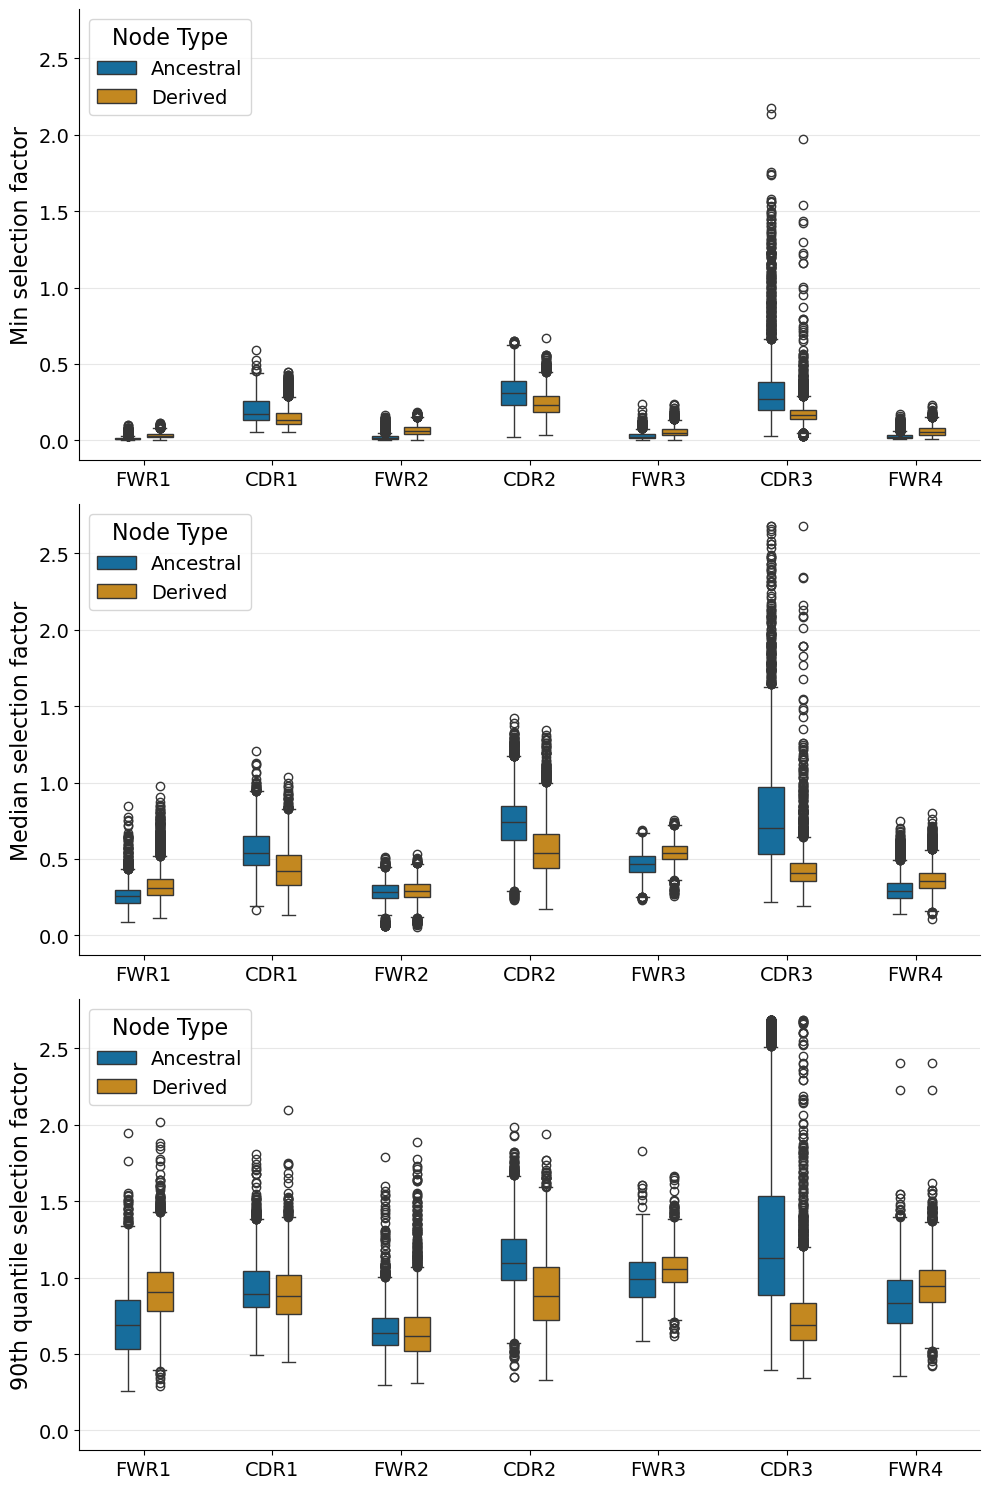

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

for statistic, ax in zip(['min', 'median', 'q90', 'max'], axes):
    ancestral_derived(region_stats_df, ax, statistic=statistic)
plt.tight_layout()
plt.show()

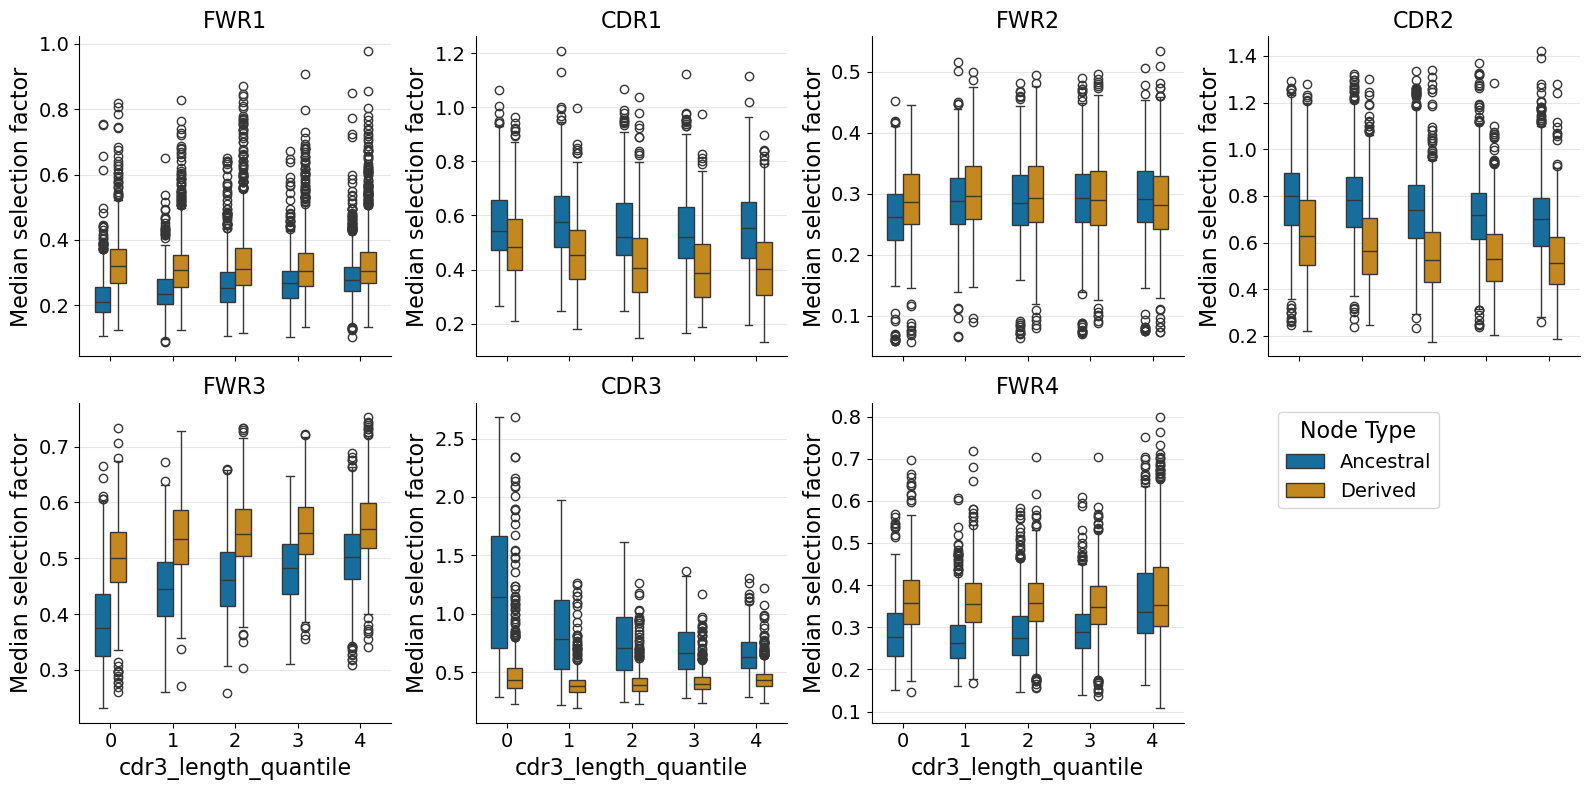

In [12]:
def get_kth_smallest_index(group, k):
    # Print group if group size is less than k
    if len(group) <= k:
        print(group)
    # Sort the group by distance and return the index of the 0-indexed kth smallest value
    return group.nsmallest(k+1, 'distance').index[k]


def plot_ancestral_derived_by_region(region_stats_df, ax, region):
    """
    Plot the median of the selection factors across regions for two sequences per clonal family: 
    the most ancestral (closest to the root) and the most derived (the farthest from the root in terms of branch length).
    
    Parameters:
    - region_stats_df: DataFrame containing region statistics.
    - ax: Matplotlib axis object where the plot will be drawn.
    - region: The region to filter the data by.
    """
    df = region_stats_df.copy()
    medians_df = df[(df['statistic'] == 'median') & (df['region'] == region)]

    # Group by sample_id and family, then find the indices of the min and max distances
    ancestral_idx = medians_df.groupby(['clonal_family', 'region'])['distance'].idxmin()
    # If one wants the kth smallest, one can use the following (note that ancestral_rank is 0-indexed)...
    # ancestral_rank = 0
    # ancestral_idx = medians_df.groupby(['clonal_family', 'region']).apply(
    #     lambda group: get_kth_smallest_index(group, ancestral_rank),
    #     include_groups=False)
    derived_idx = medians_df.groupby(['clonal_family', 'cdr3_length_quantile'])['distance'].idxmax()

    # Extract rows corresponding to ancestral and derived nodes
    ancestral_df = medians_df.loc[ancestral_idx]
    derived_df = medians_df.loc[derived_idx]

    # Mark these rows accordingly
    ancestral_df['Type'] = 'Ancestral'
    derived_df['Type'] = 'Derived'

    # Concatenate the ancestral and derived dataframes
    combined_df = pd.concat([ancestral_df, derived_df])

    sns.boxplot(
        data=combined_df,
        x='cdr3_length_quantile',
        y='dnsm',
        hue='Type',
        width=0.5,
        palette='colorblind',
        ax=ax
    )

    sns.despine()

    # Add horizontal gridlines
    ax.grid(axis='y', linestyle='-', alpha=0.3)

    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('cdr3_length_quantile', fontsize=16)
    ax.set_ylabel('Median selection factor', fontsize=16)
    ax.legend(title='Node Type', loc='upper left', fontsize=14, title_fontsize=16)

unique_regions = region_stats_df.reset_index()['region'].unique()
n_regions = len(unique_regions)

fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True)

# flatten the axes
axes = axes.flatten()

# put the legend in very last axis
axes[-1].axis('off')

for ax, region in zip(axes[:-1], unique_regions):
    plot_ancestral_derived_by_region(region_stats_df, ax, region)
    ax.set_title(f'{region}', fontsize=16)
    ax.legend_.remove()  # Remove the legend from each subplot

# Add a legend to the last axis
handles, labels = axes[0].get_legend_handles_labels()
axes[-1].legend(handles, labels, title='Node Type', loc='upper left', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()

In [13]:
class CDR3Plotter:
    def __init__(self, desired_cdr3_length, region_stats_df, seq_df, row_filter_condition=None):
        self.desired_cdr3_length = desired_cdr3_length

        self.stats_df = region_stats_df[region_stats_df["cdr3_length"] == desired_cdr3_length]
        specified_cdr3_clonal_families = set(self.stats_df['clonal_family'].values)
        self.seq_df = seq_df[seq_df.reset_index()["clonal_family"].isin(specified_cdr3_clonal_families).values].copy().reset_index()
        self.seq_df.sort_values(["clonal_family", "distance"], inplace=True)

        self.seq_df["cdr3_aa_start"] = self.seq_df["cdr3_codon_start"] // 3
        self.seq_df["cdr3_aa_xend"] = 1 + self.seq_df["cdr3_codon_end"] // 3

        # Check to make sure we indeed have a single CDR3 length.
        assert (self.seq_df["cdr3_aa_xend"] - self.seq_df["cdr3_aa_start"]).nunique() == 1

        self.seq_df["cdr3_dnsm"] = [
            row["dnsm"][row["cdr3_aa_start"]:row["cdr3_aa_xend"]]
            for _, row in self.seq_df.iterrows()
        ]
        self.seq_df["cdr3_aa"] = [
            row["seq_aa"][row["cdr3_aa_start"]:row["cdr3_aa_xend"]]
            for _, row in self.seq_df.iterrows()
        ]

        if row_filter_condition is not None:
            self.seq_df = self.seq_df[self.seq_df.apply(row_filter_condition, axis=1)].copy().reset_index(drop=True)

        ancestral_idxs = self.seq_df.groupby("clonal_family")["distance"].idxmin()
        self.ancestral_seq_df = self.seq_df.loc[ancestral_idxs.values].copy().reset_index()
        self.ancestral_dnsm = np.stack(self.ancestral_seq_df["cdr3_dnsm"].values)
        
        # Create a temporary figure to get the default DPI
        temp_fig = plt.figure()
        self.dpi = temp_fig.dpi
        plt.close(temp_fig)  # Close the temporary figure

        # print the number of clonal families with that CDR3 length
        print(f"Number of clonal families with CDR3 length {desired_cdr3_length}: {len(self.ancestral_dnsm)}")

    @property
    def clonal_family_count(self):
        return len(self.ancestral_dnsm)

    def ancestral_dnsm_heatmap(self):
        fig_height = 2*len(self.ancestral_dnsm)/self.dpi
        fig_height = max(fig_height, 5)
        fig, ax = plt.subplots(figsize=(12, fig_height))
        im = ax.imshow(self.ancestral_dnsm, aspect='auto', cmap='viridis', interpolation='nearest')
        ax.set_xlabel("CDR3 sites")
        ax.set_ylabel("Ancestral sequences for each clonal family")
        ax.set_yticks([])
        fig.colorbar(im, ax=ax, label='DNSM Value')
        return fig

    def ancestral_dnsm_boxplot(self, ax=None):
        ancestral_dnsm_df = pd.DataFrame(self.ancestral_dnsm)
        if ax is None:
            fig, ax = plt.subplots(figsize=(7, 6))
            ax.set_title("Ancestral selection factors by CDR3 site across clonal families")
        else:
            fig = ax.figure
        sns.boxplot(data=ancestral_dnsm_df, color="lightgray", ax=ax)
        # Add a gray dashed horizontal line at y=1
        ax.axhline(1, color='gray', linestyle='--')
        ax.set_xlabel("CDR3 sites")
        ax.set_ylabel(f"Selection factors ({self.clonal_family_count} families)")
        sns.despine()
        return fig

    def ancestral_cdr3_logo(self, ax=None):
        sequences = self.ancestral_seq_df["cdr3_aa"]

        # Create a count matrix from the sequences
        count_matrix = logomaker.alignment_to_matrix(sequences, to_type='counts')

        # Create a logo plot using the count matrix
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.set_title('Ancestral CDR3 Sequence Logo')
        else:
            fig = ax.figure
        logo = logomaker.Logo(count_matrix, ax=ax, color_scheme='NajafabadiEtAl2017')

        # Customize the plot (optional)
        logo.style_spines(visible=False)
        logo.style_spines(spines=['left', 'bottom'], visible=True)
        logo.style_xticks(rotation=90, fmt='%d', anchor=0)

        return fig

    def build_dnsm_arrays_and_distances(self):
        clonal_families = self.seq_df["clonal_family"].unique()

        arrays = []
        distances = []

        for clonal_family in clonal_families:
            family_df = self.seq_df[self.seq_df["clonal_family"] == clonal_family]
            family_dnsm = np.stack(family_df["cdr3_dnsm"].values)
            arrays.append(family_dnsm)
            distances.append(family_df["distance"].values)

        return arrays, distances


    def dnsm_heatmap_by_family(self):
        arrays, distances = self.build_dnsm_arrays_and_distances()
        
        # Insert rows of NaNs between arrays
        nan_row = np.full((1, self.desired_cdr3_length), np.nan)
        combined_array = np.vstack([np.vstack([array, nan_row]) for array in arrays[:-1]] + [arrays[-1]])
        combined_array = np.vstack(combined_array)

        # Add NaNs between arrays in distances and flatten
        nan_distances = []
        for distance_array in distances:
            nan_distances.extend(distance_array)
            nan_distances.append(np.nan)
        # Remove the last NaN as it's not needed
        nan_distances = nan_distances[:-1]
        distances = nan_distances
        
        fig_height = 3*len(self.seq_df)/self.dpi
        fig, ax = plt.subplots(1, 2, figsize=(4, fig_height), gridspec_kw={'width_ratios': [1, 100]})

        # Sidebar for distances
        ax[0].imshow(np.array(distances).reshape(-1, 1), aspect='auto', cmap='Greys', vmin=np.nanmin(distances), vmax=np.nanmax(distances))
        ax[0].set_title('')
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        # Main DNSM heatmap
        im = ax[1].imshow(combined_array, aspect='auto', cmap='viridis', interpolation='nearest')
        ax[1].set_title(f'DNSM for families w/ CDR3 length {self.desired_cdr3_length}')
        ax[1].set_xlabel('Position')
        ax[1].set_ylabel('')
        ax[1].set_yticks([])

        plt.tight_layout()

        return fig
    
    
    def line_clonal_family_plot(self, statistic=np.median, ax=None):
        if ax is None:
            ax = plt.gca()
            
        arrays, distances = self.build_dnsm_arrays_and_distances()
        reduced = [statistic(array, axis=1) for array in arrays]
        
        for distance_arr, reduced_arr in zip(distances, reduced):
            # Use the HSL color space to ensure equal saturation
            hue = np.random.rand()
            color = plt.cm.hsv(hue)  # Get a color from the HSV colormap with equal saturation and value
            ax.plot(distance_arr, reduced_arr, color=color, alpha=0.2)
            ax.set_title(f"CDR3 length = {self.desired_cdr3_length}")
            ax.set_xlabel("Distance")
            ax.set_ylabel(f"{statistic.__name__} DNSM")
            sns.despine()
            
        return ax

        

desired_cdr3_length = 8

def second_to_last_in_CDR3_is_D(row):
    return row['cdr3_aa'][-2] == 'D'

def second_to_last_in_CDR3_is_not_D(row):
    return row['cdr3_aa'][-2] != 'D'

plotter = CDR3Plotter(desired_cdr3_length, region_stats_df, seq_df, row_filter_condition=second_to_last_in_CDR3_is_D)

Number of clonal families with CDR3 length 8: 66


In [14]:

# fig_ancestral_derived = plotter.ancestral_derived()
# plt.show(fig_ancestral_derived)
# 
# fig_dnsm_heatmap = plotter.ancestral_dnsm_heatmap()
# plt.show(fig_dnsm_heatmap)
# 
# fig_dnsm_boxplot = plotter.ancestral_dnsm_boxplot()
# plt.tight_layout()
# plt.show(fig_dnsm_boxplot)
# 
# fig_logo = plotter.ancestral_cdr3_logo()
# plt.show(fig_logo)
# 
# fig_dnsm_heatmap_by_family = plotter.dnsm_heatmap_by_family()
# plt.show(fig_dnsm_heatmap_by_family)

Number of clonal families with CDR3 length 8: 89
Number of clonal families with CDR3 length 9: 162
Number of clonal families with CDR3 length 10: 209
Number of clonal families with CDR3 length 11: 323
Number of clonal families with CDR3 length 12: 361
Number of clonal families with CDR3 length 13: 392
Number of clonal families with CDR3 length 14: 509
Number of clonal families with CDR3 length 15: 451
Number of clonal families with CDR3 length 16: 391
Number of clonal families with CDR3 length 17: 266
Number of clonal families with CDR3 length 18: 240
Number of clonal families with CDR3 length 19: 182
Number of clonal families with CDR3 length 20: 110
Number of clonal families with CDR3 length 21: 80
Number of clonal families with CDR3 length 22: 67
Number of clonal families with CDR3 length 8: 66
Number of clonal families with CDR3 length 9: 113
Number of clonal families with CDR3 length 10: 163
Number of clonal families with CDR3 length 11: 250
Number of clonal families with CDR3 len

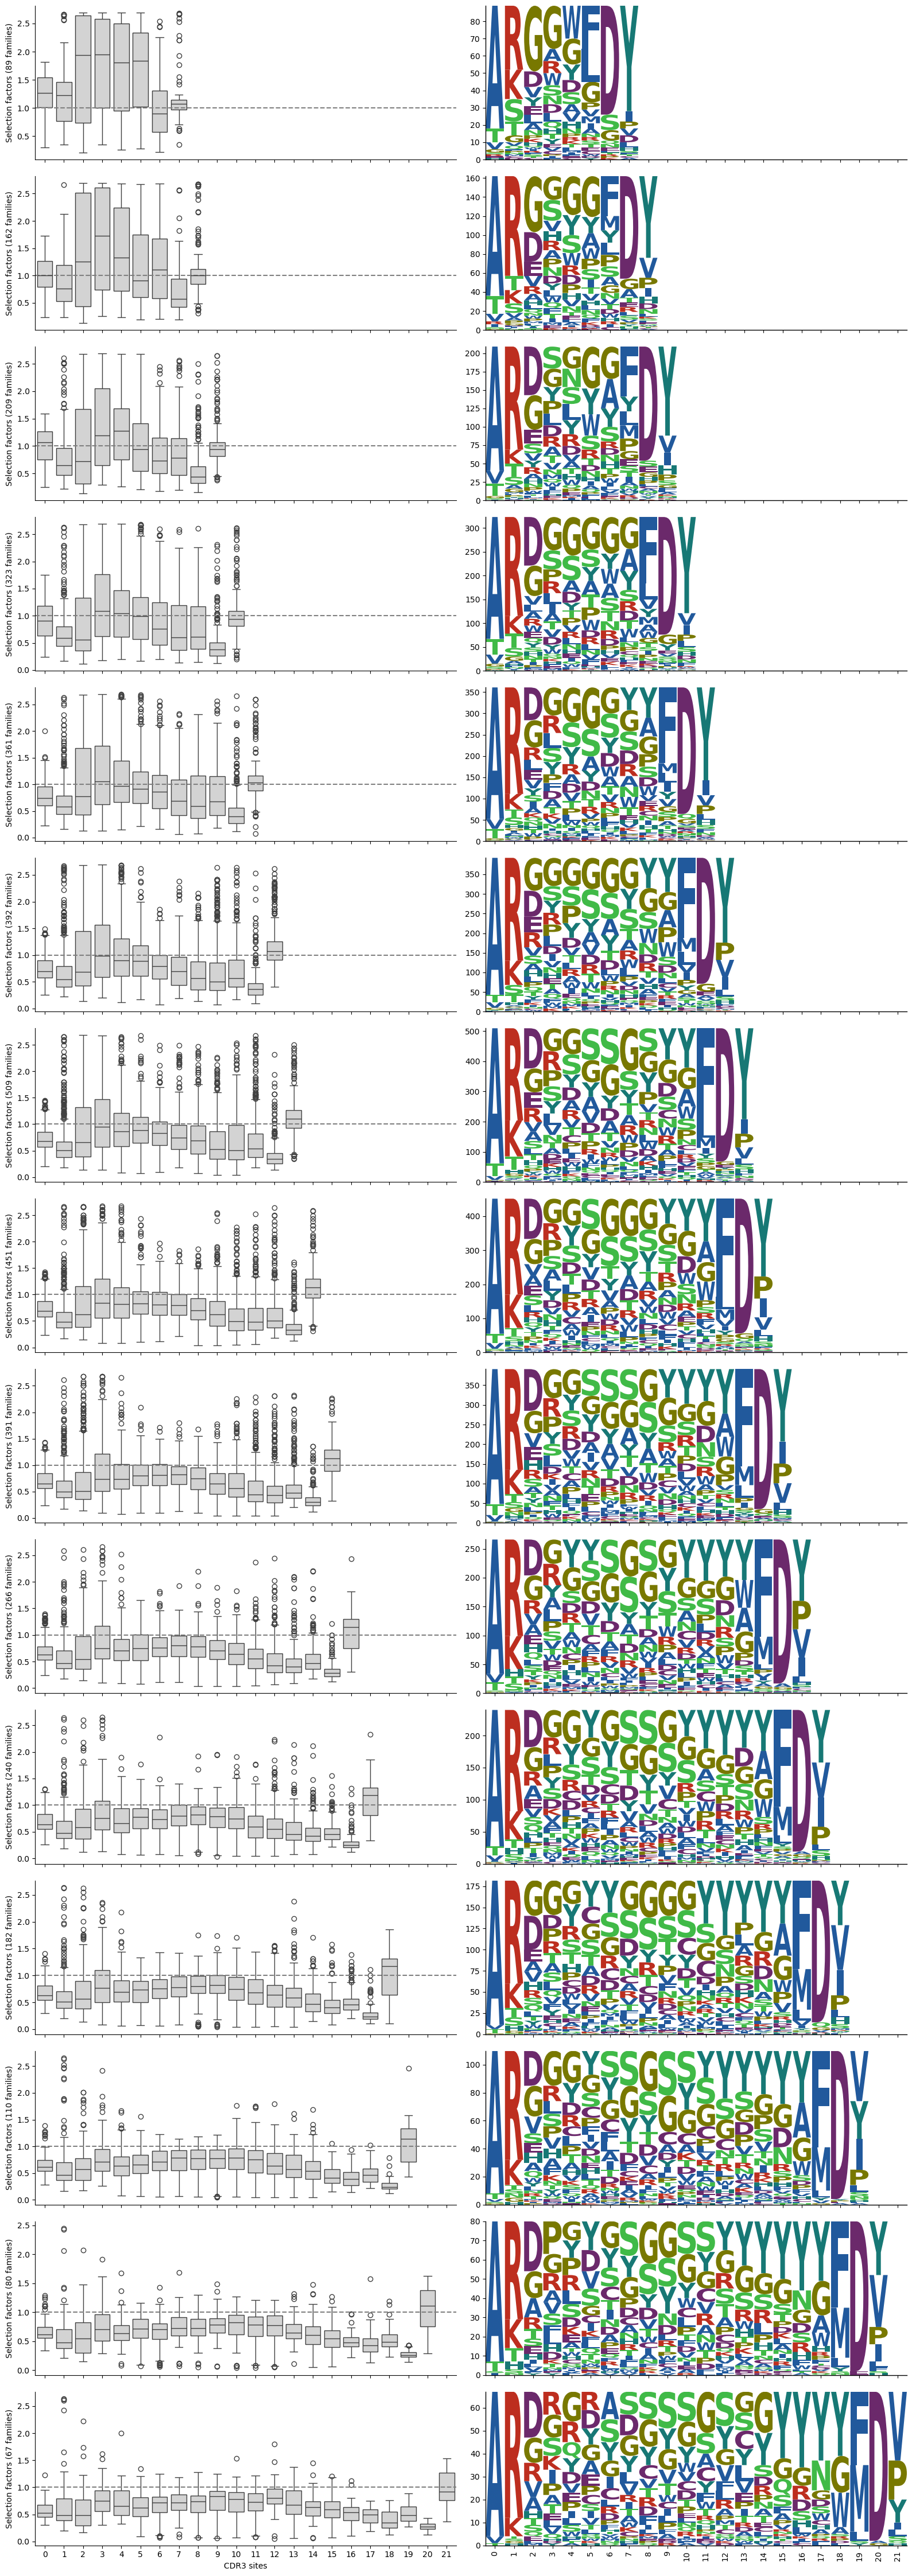

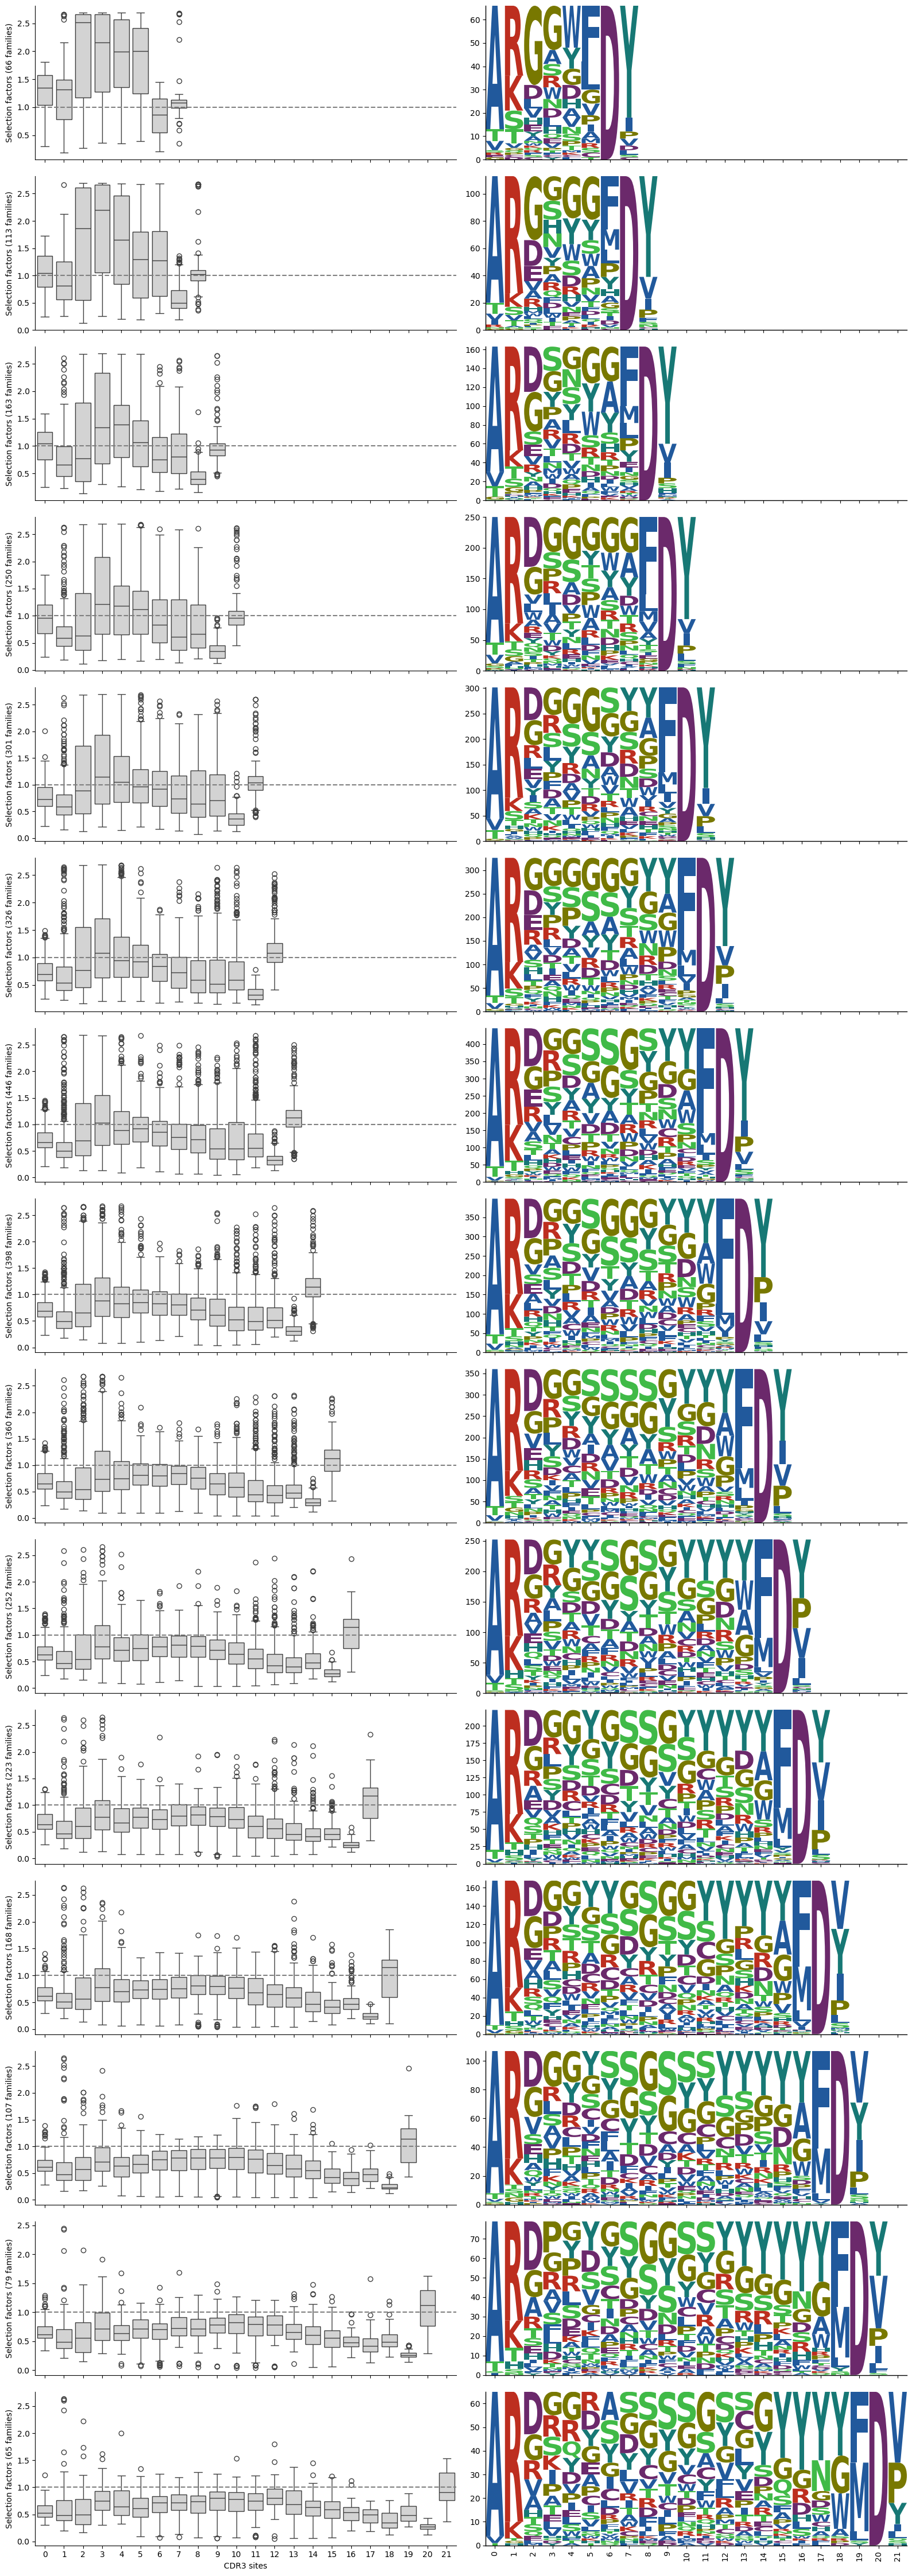

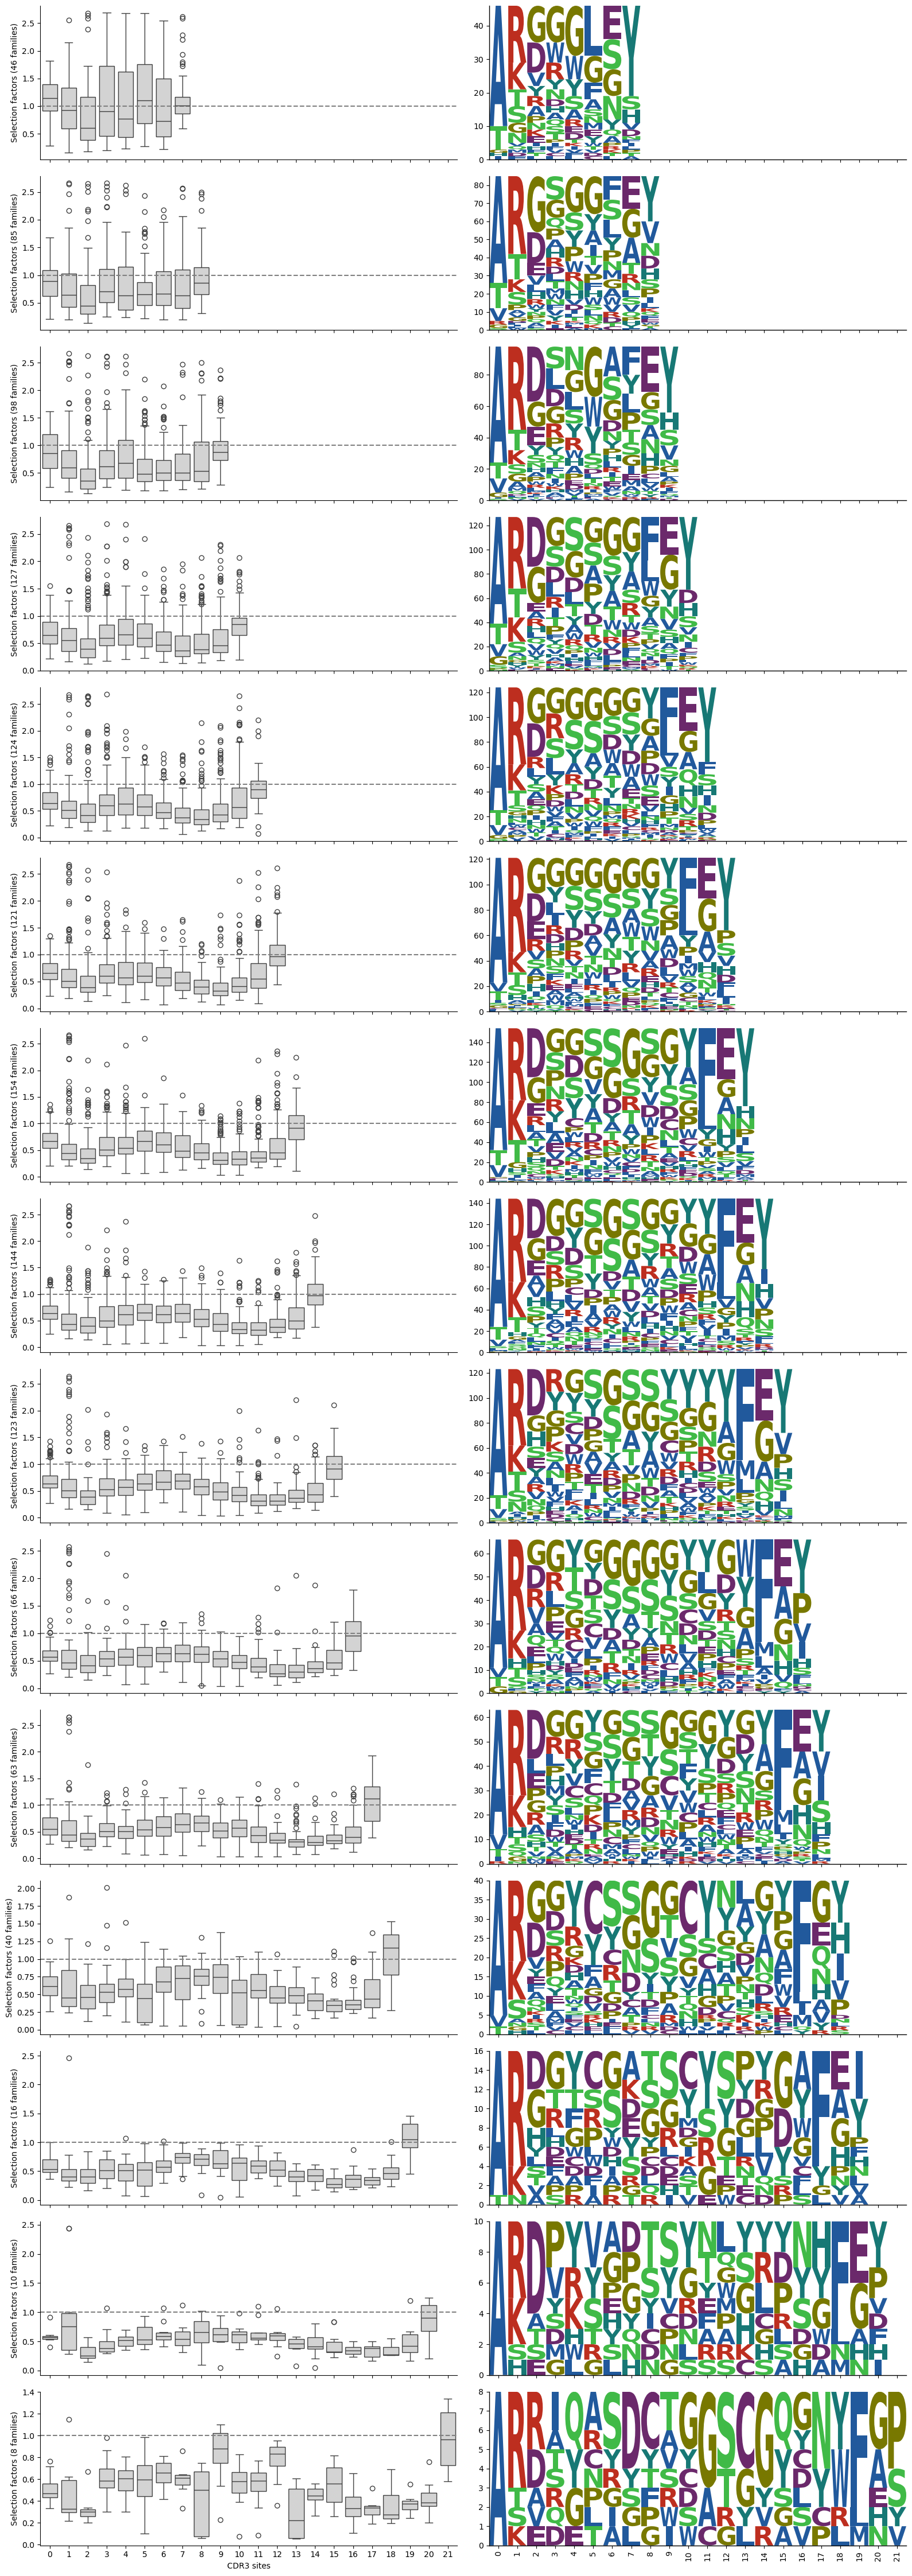

In [15]:
min_length = 8
max_length = 22
length_count = max_length - min_length + 1

def ancestral_dnsm_boxplots_and_logos(row_filter_condition, filename):
    ancestral_dnsm_dict = {}

    # Create a 2D grid of subplots
    fig, axes = plt.subplots(length_count, 2, figsize=(16, 3*length_count), sharex='col')

    # Iterate over the 2D grid and plot the boxplots and sequence logos
    for i, desired_cdr3_length in enumerate(range(min_length, max_length + 1)):
        plotter = CDR3Plotter(desired_cdr3_length, region_stats_df, seq_df, row_filter_condition=row_filter_condition)
        plotter.ancestral_dnsm_boxplot(ax=axes[i, 0])
        plotter.ancestral_cdr3_logo(ax=axes[i, 1])
        ancestral_dnsm_dict[desired_cdr3_length] = plotter.ancestral_dnsm

    plt.tight_layout()

    fig.savefig(os.path.join(figures_dir, filename))

    return ancestral_dnsm_dict

ancestral_dnsm_dict_all = ancestral_dnsm_boxplots_and_logos(None, "ancestral_dnsm_boxplots_and_logos.svg")
ancestral_dnsm_dict_with_D = ancestral_dnsm_boxplots_and_logos(second_to_last_in_CDR3_is_D, "ancestral_dnsm_boxplots_and_logos_with_D.svg")
ancestral_dnsm_dict_without_D = ancestral_dnsm_boxplots_and_logos(second_to_last_in_CDR3_is_not_D, "ancestral_dnsm_boxplots_and_logos_without_D.svg")

/tmp/ipykernel_3493570/2176008739.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3493570/2176008739.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_3493570/2176008739.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


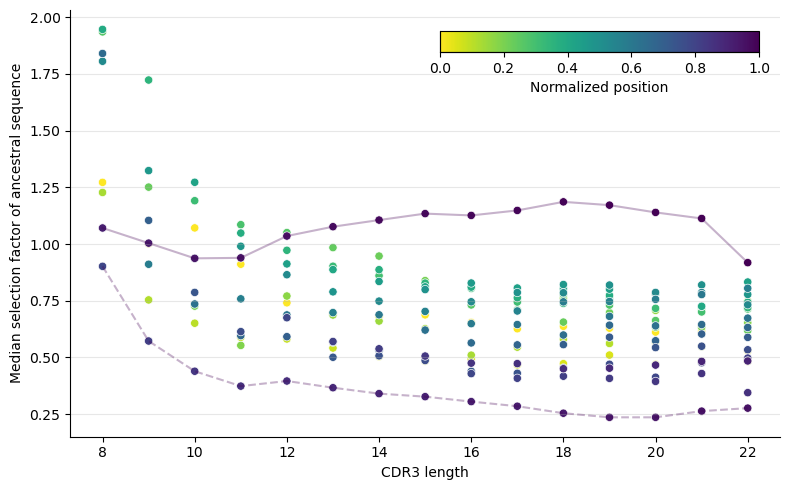

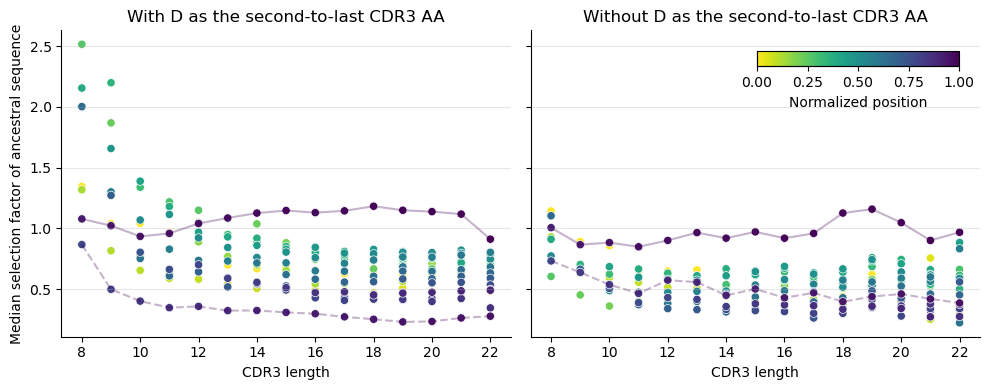

In [16]:
def plot_ancestral_dnsm_by_cdr3_length(ancestral_dnsm_dict, ax, show_cbar=True):
    to_stack = []

    for cdr3_length in ancestral_dnsm_dict.keys():
        df = pd.DataFrame({"median selection factor": np.median(ancestral_dnsm_dict[cdr3_length], axis=0)})
        df["CDR3 length"] = cdr3_length
        df.reset_index(inplace=True)
        df.rename(columns={"index": "position"}, inplace=True)
        df["position from end"] = cdr3_length - df["position"] - 1
        df["normalized position"] = df["position"] / cdr3_length
        to_stack.append(df)

    stacked_df = pd.concat(to_stack, ignore_index=True)

    def position_from_end_rows(position_from_end):
        return stacked_df[stacked_df["position from end"] == position_from_end]
    last_position = position_from_end_rows(0)
    second_to_last_position = position_from_end_rows(1)

    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
    sm.set_array([])
    most_purple_color = sm.to_rgba(1.0)

    sns.lineplot(data=last_position, x="CDR3 length", y="median selection factor", color=most_purple_color, alpha=0.3, ax=ax) #, linestyle='dashed')
    sns.lineplot(data=second_to_last_position, x="CDR3 length", y="median selection factor", color=most_purple_color, alpha=0.3, ax=ax, linestyle='dashed')
    scatter = sns.scatterplot(data=stacked_df, x="CDR3 length", y="median selection factor", hue="normalized position", palette="viridis_r", ax=ax, legend=False)

    ax.yaxis.grid(True, linestyle='-', alpha=0.3)
    ax.set_ylabel("Median selection factor of ancestral sequence")

    if show_cbar:
        # Creating an inset axis for the color bar with correct positioning
        cax = inset_axes(ax, width="45%", height="5%", loc='upper right', borderpad=1.5)  # Adjust width and height as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cbar.set_label("Normalized position")

    sns.despine()
    plt.tight_layout()

fig, ax = plt.subplots(figsize=(8, 5))
plot_ancestral_dnsm_by_cdr3_length(ancestral_dnsm_dict_all, ax)
fig.savefig(os.path.join(figures_dir, "median_ancestral_dnsm_per_site_by_cdr3_length.svg"))

# make two plots stacked on top of one another, each 8 wide and 5 tall
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_ancestral_dnsm_by_cdr3_length(ancestral_dnsm_dict_with_D, axes[0], show_cbar=False)
plot_ancestral_dnsm_by_cdr3_length(ancestral_dnsm_dict_without_D, axes[1])
axes[0].set_title("With D as the second-to-last CDR3 AA")
axes[1].set_title("Without D as the second-to-last CDR3 AA")
plt.tight_layout()
fig.savefig(os.path.join(figures_dir, "median_ancestral_dnsm_per_site_by_cdr3_length_with_and_without_D.svg"))


## Plotting individual families

In [17]:
def plot_family_df(family_df):
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as necessary

    # Create a colormap and normalizer
    depths = sorted(family_df['depth'].unique())
    norm = Normalize(vmin=min(depths), vmax=max(depths))
    color_map = cm.ScalarMappable(norm=norm, cmap='viridis_r')

    # Plotting sequence data
    for depth in depths:
        depth_df = family_df[family_df['depth'] == depth].reset_index(drop=True)
        for i, row in depth_df.iterrows():
            ax.plot(range(1, len(row['dnsm']) + 1), row['dnsm'], color=color_map.to_rgba(depth))

    # Define CDR colors (these are just examples, choose colors as needed)
    cdr_colors = {
        'cdr1': mcolors.XKCD_COLORS['xkcd:blue'],
        'cdr2': mcolors.XKCD_COLORS['xkcd:green'],
        'cdr3': mcolors.XKCD_COLORS['xkcd:red']
    }

    # Extracting the first row for CDR regions
    first_row = family_df.iloc[0]
    cdr_keys = ['cdr1', 'cdr2', 'cdr3']
    for cdr in cdr_keys:
        start_col = f'{cdr}_codon_start'
        end_col = f'{cdr}_codon_end'
        if start_col in family_df.columns and end_col in family_df.columns:
            start = int(first_row[start_col]) // 3 + 1
            end = int(first_row[end_col]) // 3 + 1
            ax.hlines(y=ax.get_ylim()[0], xmin=start, xmax=end, colors=cdr_colors[cdr], linewidths=5, alpha=0.5, label=f'{cdr}')

    clonal_family = family_df['clonal_family'].iloc[0]
    ax.set_title(f"Family {clonal_family}")

    # Add a color bar
    color_map.set_array([])
    cb = plt.colorbar(color_map, ax=ax, orientation='vertical')
    cb.set_label('Depth')

    # Add legend for CDRs
    ax.legend()

    return fig, ax


In [23]:
def make_family_df(clonal_family):
    family_df = pcp_df[pcp_df["clonal_family"] == clonal_family].reset_index(drop=True)
    family_df["parent_aa"] = family_df["parent_heavy"].apply(translate_sequence)
    family_df["dnsm"] = crepe(family_df["parent_aa"])
    return family_df


def plot_family_df(family_df):
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as necessary

    # Create a colormap and normalizer
    depths = sorted(family_df['depth'].unique())
    norm = Normalize(vmin=min(depths), vmax=max(depths))
    color_map = cm.ScalarMappable(norm=norm, cmap='viridis_r')

    # Plotting sequence data
    for depth in depths:
        depth_df = family_df[family_df['depth'] == depth].reset_index(drop=True)
        for i, row in depth_df.iterrows():
            ax.plot(range(1, len(row['dnsm']) + 1), row['dnsm'], color=color_map.to_rgba(depth))

    # Define CDR colors
    cdr_colors = {
        'cdr1': mcolors.XKCD_COLORS['xkcd:blue'],
        'cdr2': mcolors.XKCD_COLORS['xkcd:green'],
        'cdr3': mcolors.XKCD_COLORS['xkcd:red']
    }

    # Extracting the first row for CDR regions
    first_row = family_df.iloc[0]
    cdr_keys = ['cdr1', 'cdr2', 'cdr3']
    cdr_y = ax.get_ylim()[0]
    for cdr in cdr_keys:
        start_col = f'{cdr}_codon_start'
        end_col = f'{cdr}_codon_end'
        if start_col in family_df.columns and end_col in family_df.columns:
            start = int(first_row[start_col]) // 3 + 1
            end = int(first_row[end_col]) // 3 + 1
            ax.hlines(y=cdr_y, xmin=start, xmax=end, colors=cdr_colors[cdr], linewidths=5, alpha=0.5, label=f'{cdr}')

    family = family_df['family'].iloc[0]
    ax.set_title(f"Family {family}")

    # Add a color bar
    color_map.set_array([])
    cb = plt.colorbar(color_map, ax=ax, orientation='vertical')
    cb.set_label('Depth')

    # Add legend for CDRs
    ax.legend()

    return fig, ax


def plot_family(clonal_family):
    family_df = make_family_df(clonal_family)
    return plot_family_df(family_df)


In [19]:
pcp_df["sample_id"].value_counts()

sample_id
d1    47686
d4    13485
d3     7274
d2     6379
Name: count, dtype: int64

In [20]:
sample_id = "d1"
pcp_df[pcp_df["sample_id"] == sample_id]["family"].value_counts().head()


family
151921    381
142704    371
174921    194
1308      168
142788    165
Name: count, dtype: int64

In [21]:
def find_aa_differences(parent_aa, child_aa):
    return [(i+1, parent_aa[i], child_aa[i]) for i in range(len(parent_aa)) if parent_aa[i] != child_aa[i]]

/tmp/ipykernel_3493570/2550374609.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Figure size 1200x600 with 2 Axes>,
 <Axes: title={'center': 'Family 151921 : child == Node3'}>)

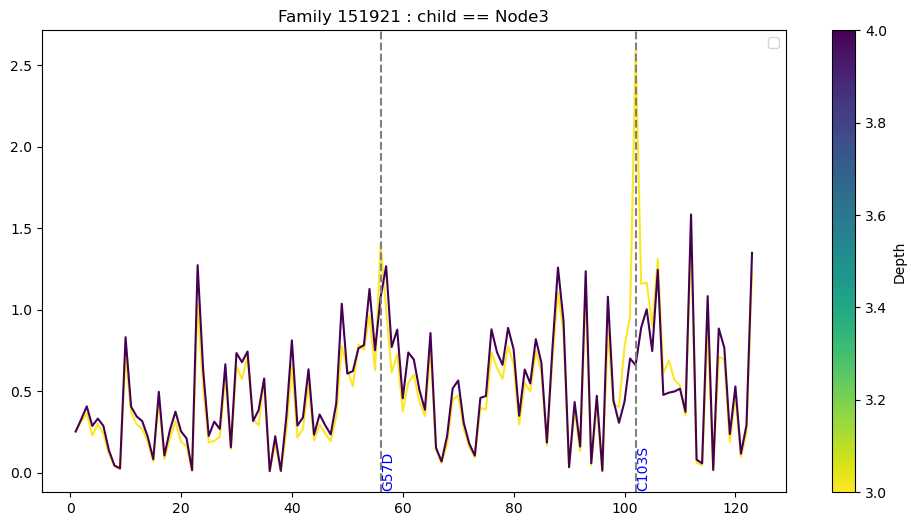

In [24]:
def plot_pcp_df(family_df, index):
    child_name = family_df.loc[index, "child_name"]
    child_index = family_df[family_df["parent_name"] == child_name].index[0]
    indices = [index, child_index]
    fig, ax = plot_family_df(family_df.iloc[indices])

    # Find differences
    differences = find_aa_differences(family_df.loc[index, "parent_aa"], family_df.loc[child_index, "parent_aa"])

    # Mark differences on the plot
    for diff in differences:
        pos, parent_aa, child_aa = diff
        ax.axvline(x=pos, color='gray', linestyle='--')  # Plot vertical line for each difference
        change_label = f'{parent_aa}{pos + 1}{child_aa}'  # Create label from differences
        ax.text(0.2+pos, 0.01+ax.get_ylim()[0], change_label, rotation=90, verticalalignment='bottom', color='blue')

    # append the child name to the title
    ax.set_title(f"{ax.get_title()} : child == {child_name}")

    return fig, ax

plot_pcp_df(make_family_df("d1_151921"), 0)


In [25]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def generate_family_plots(family_df):
    # Create a PDF file for the plots
    with PdfPages(f"family_{family_df['family'].iloc[0]}.pdf") as pdf:
        for index, row in family_df.iterrows():
            # Check if the current row has a corresponding child row
            if row['child_name'] in family_df['parent_name'].values:
                # Generate the plot for the current parent-child pair
                fig, ax = plot_pcp_df(family_df, index)

                # Save the current figure to the PDF
                pdf.savefig(fig)
                plt.close(fig)  # Close the figure to free memory

# generate_family_plots(make_family_df("d1_151921"))